In [1]:
from DBapi import *
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [2]:
# 初步排雷,获得初步筛选的股票池
# 1. 过去一个月里，流通市值小于20亿 并且 市盈率ttm > 0
# 2. 上市时间 > 365

def get_stock_list(current_date):
    one_month_ago = (datetime.strptime(current_date, '%Y-%m-%d') - timedelta(days=30)).strftime('%Y-%m-%d')
    one_year_ago = (datetime.strptime(current_date, '%Y-%m-%d') - timedelta(days=365)).strftime('%Y-%m-%d')

    conn = sqlite3.connect('/Users/syesw/Desktop/Quant DataBase/AShares.db')

    # query1筛选市盈率和流通市值
    query1 = '''
    SELECT DISTINCT order_book_id
    FROM stocks_factors
    WHERE pe_ratio_ttm > 0
        AND market_cap < 2000000000
        AND date BETWEEN date(?) AND date(?)
    '''

    # query2筛选上市时间 深圳主板公司 XSHE
    query2 = '''
    SELECT DISTINCT order_book_id
    FROM stocks_info
    WHERE date(listed_date) < date(?) AND exchange = 'XSHE'
    '''

    df1 = pd.read_sql_query(query1, conn, params=(one_month_ago, current_date,))
    df2 = pd.read_sql_query(query2, conn, params=(one_year_ago,))

    conn.close()

    stock_list = list(pd.merge(df1, df2, on='order_book_id')['order_book_id'])
    
    return stock_list

In [3]:
# 获取因子排名前10的股票
def get_top_stocks(d1, stock_list):
    # 连接到SQLite数据库
    conn = sqlite3.connect('/Users/syesw/Desktop/Quant DataBase/AShares.db')
    cursor = conn.cursor()
    order_book_ids = ','.join(['"{}"'.format(id) for id in stock_list])
    
    d1 = datetime.strptime(d1, '%Y-%m-%d')
    d2 = d1 + timedelta(days=1)
    d2 = d2.strftime('%Y-%m-%d')
    
    query = f"""
        SELECT order_book_id
        FROM stocks_factors
        WHERE order_book_id IN ({order_book_ids}) AND date BETWEEN '{d1}' AND '{d2}' AND market_cap_2 > 10
        ORDER BY market_cap_2
        LIMIT 10;
    """

    cursor.execute(query)
    results = cursor.fetchall()
    order_book_ids = [result[0] for result in results]
    
    cursor.close()
    conn.close()
    
    return order_book_ids

In [4]:
import backtrader as bt

In [5]:
stock = get_factors('600689.XSHG', ['market_cap'], '2020-01-01', '2021-01-01')

In [6]:
stock['date'] = pd.to_datetime(stock['date'])
stock['date'] = stock['date'].dt.strftime('%Y-%m-%d')
trade_dates = stock['date'].to_list()
# trade_dates是交易日
# print(trade_dates[:5])

# 计算调仓时间
trade = pd.to_datetime(trade_dates)
df = pd.DataFrame({'date': trade_dates})
df['date'] = pd.to_datetime(df['date'])
first_trading_dates = df.groupby(df['date'].dt.to_period('M')).first()
formatted_dates = first_trading_dates['date'].dt.strftime('%Y-%m-%d').tolist()

# 注意时间都以str来储存，方便进行比较
formatted_dates

['2020-01-02',
 '2020-02-03',
 '2020-03-02',
 '2020-04-01',
 '2020-05-06',
 '2020-06-01',
 '2020-07-01',
 '2020-08-03',
 '2020-09-01',
 '2020-10-09',
 '2020-11-02',
 '2020-12-01']

In [7]:
# 把调仓储存起来
stocks_dict = {}
all_stocks = []
for d1 in tqdm(formatted_dates):
    # 每个月先初步筛选
    stock_list = get_stock_list(d1)
    all_stocks.extend(stock_list)
    # 再筛选排序后的因子
    top_stocks = get_top_stocks(d1, stock_list)
    stocks_dict[d1] = top_stocks

100%|███████████████████████████████████████████| 12/12 [03:13<00:00, 16.09s/it]


In [8]:
all_stocks = list(set(all_stocks))

In [10]:
# 把这些拿去喂就行了
# all_stocks

In [11]:
# 交易策略
class Small_Cap_Strategy(bt.Strategy):
    def __init__(self):
        self.trade_log = []  # 初始化交易日志
        self.dates = []
        self.vals = []
        self.order = None
        self.rebalance_dates = formatted_dates # 调仓日期列表

    def notify_order(self, order):
        # 重构交易记录
        if order.status in [order.Completed]:
            if order.isbuy():
                trade_type = 'BUY'
            elif order.issell():
                trade_type = 'SELL'
            
            self.trade_log.append({
                'Date': bt.num2date(order.executed.dt),
                'Stock': order.data._name,
                'Type': trade_type,
                'Price': order.executed.price,
                'Size': order.executed.size
            })

    def next(self):
        # 获取当前日期
        current_date = str(self.datas[0].datetime.date(0))
        #print(current_date)

        # 检查是否是指定的调仓日期
        if current_date in self.rebalance_dates:
            self.rebalance_portfolio(current_date)
            
        self.vals.append(self.broker.getvalue()) # 更新净值
        self.dates.append(self.datas[0].datetime.date(0)) 
        
    def rebalance_portfolio(self, current_date):
        # 获取对应日期的股票列表
        
        assets = stocks_dict[current_date]
        positions = self.getpositions()
        
        # 不在列表就卖掉
        for data in positions:
            if data._name not in assets:
                self.close(data)

        # 分配资金至目标股票
        if len(assets) > 0:
            weight = 1.0 / len(assets)
            
            for stock in assets:
                self.order_target_percent(stock, target=weight)

In [12]:

conn = sqlite3.connect('/Users/syesw/Desktop/Quant DataBase/AShares.db')
query = '''
    SELECT s.order_book_id, s.date, s.open, s.close, s.high, s.low, s.volume
    FROM stocks_fundamentals AS s
    INNER JOIN stocks_info AS i ON s.order_book_id = i.order_book_id
    WHERE i.exchange = 'XSHE'
'''
df = pd.read_sql_query(query, conn)
conn.close()

In [13]:
#'''
#df['date'] = pd.to_datetime(df['date'])
#df['date'] = df['date'].dt.date
#df['date'] = pd.to_datetime(df['date'])
#df['date']
#'''

In [14]:
def get_clean_stock_data(df, order_book_id, start_time=None, end_time=None):
    filtered_df = df[df['order_book_id'] == order_book_id]

    filtered_df['date'] = pd.to_datetime(df['date'])
    filtered_df['date'] = filtered_df['date'].dt.date
    filtered_df['date'] = pd.to_datetime(df['date'])
    
    filtered_df.index = filtered_df['date']
    filtered_df = filtered_df.drop(['order_book_id', 'date'], axis=1)
    filtered_df['openinterest'] = 0
    
    if start_time is not None:
        filtered_df = filtered_df.loc[start_time:]
    if end_time is not None:
        filtered_df = filtered_df.loc[:end_time]
    
    return filtered_df

In [15]:
#all_stocks = df['order_book_id'].unique().tolist()
#len(all_stocks)

In [16]:
cerebro = bt.Cerebro()

start_date = datetime(2020,1,1)
end_date = datetime(2021,1,1)

In [17]:
st = get_clean_stock_data(df, '300720.XSHE', start_date, end_date)
type(st.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
# feed数据
for stock_code in tqdm(all_stocks):
    stock_data = get_clean_stock_data(df, stock_code, start_date, end_date)
    # print(stock_data)
    # 喂给cerebro
    feed = bt.feeds.PandasData(dataname =stock_data, fromdate=start_date, todate=end_date)
    #print(feed)
    cerebro.adddata(feed, name=stock_code)
    

100%|█████████████████████████████████████████| 265/265 [34:27<00:00,  7.80s/it]


In [19]:
cerebro.addstrategy(Small_Cap_Strategy)
cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(0.0002)

results = cerebro.run()
strategy = results[0]

In [20]:
#final_balance = cerebro.broker.getvalue()
#final_balance

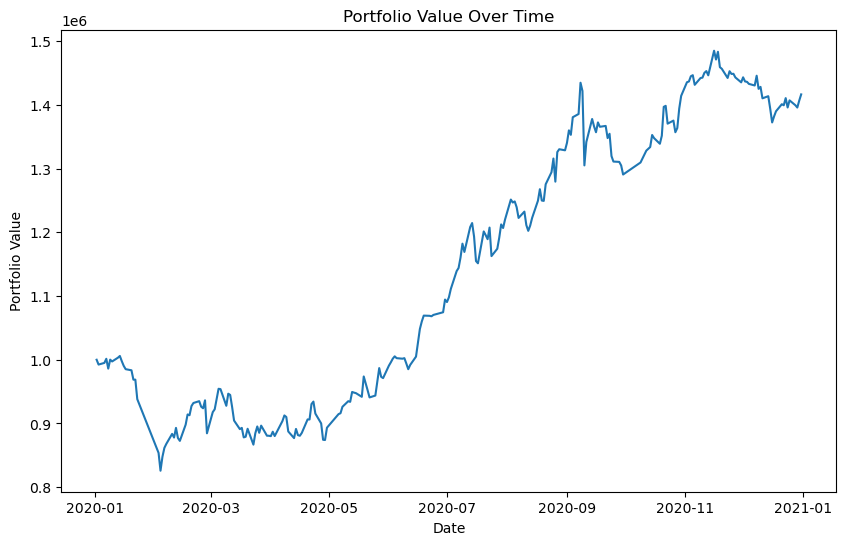

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(strategy.dates, strategy.vals)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

In [24]:
# 计算统计指标
end_value = cerebro.broker.get_value()
start_value = results[0].broker.startingcash
pnl = end_value - start_value

T = 1
annualized_return = (pnl / start_value)

# 输出总收益和年化收益率
print(f"回测结束，总收益：{pnl}")
print(f"年化收益率：{annualized_return}")

回测结束，总收益：416549.68905910035
年化收益率：0.41654968905910034
